2022-06-07_09-15-58
Red
Green
Blue


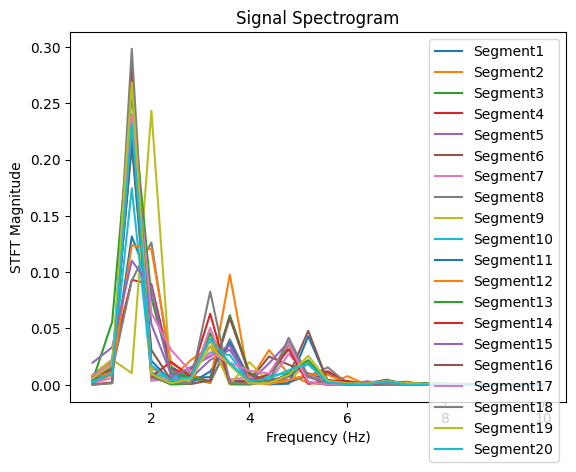

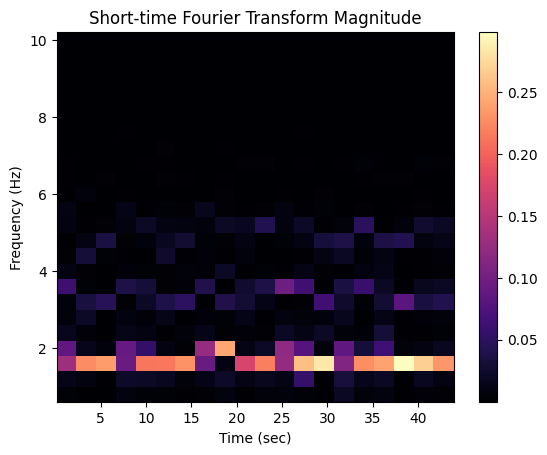

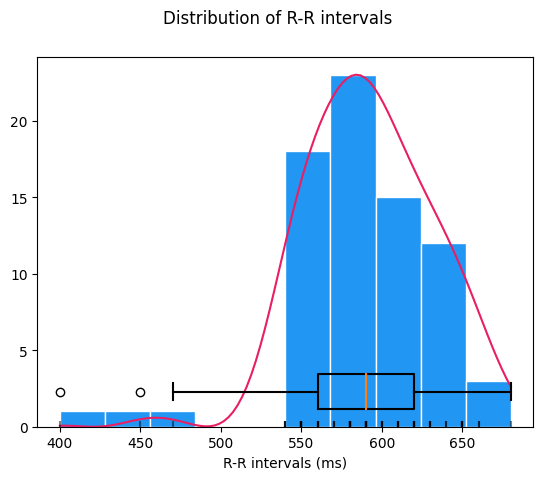

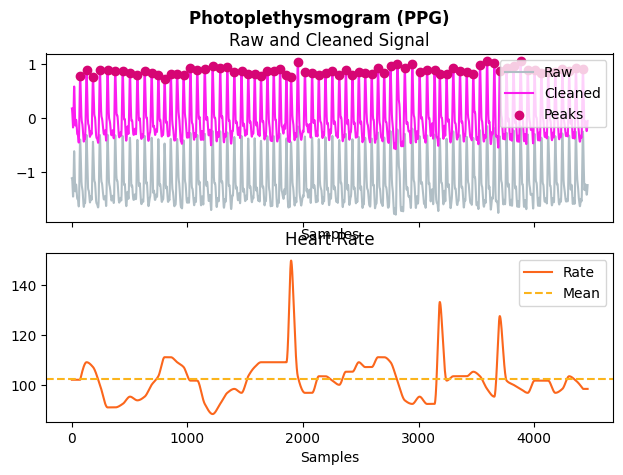

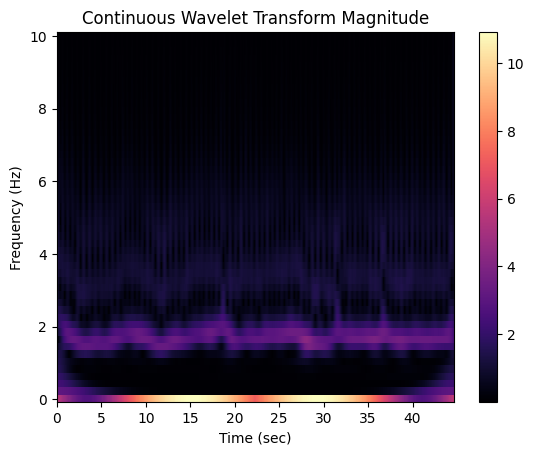

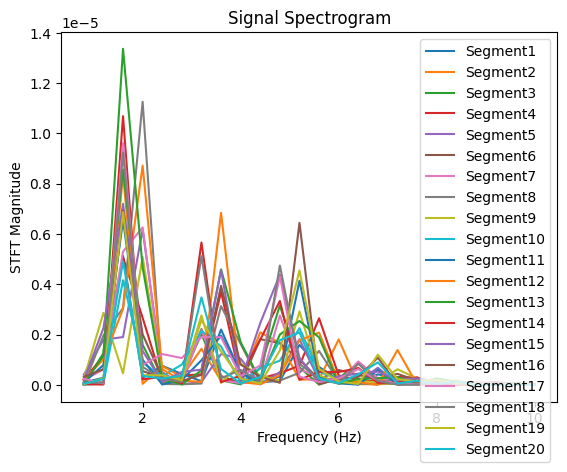

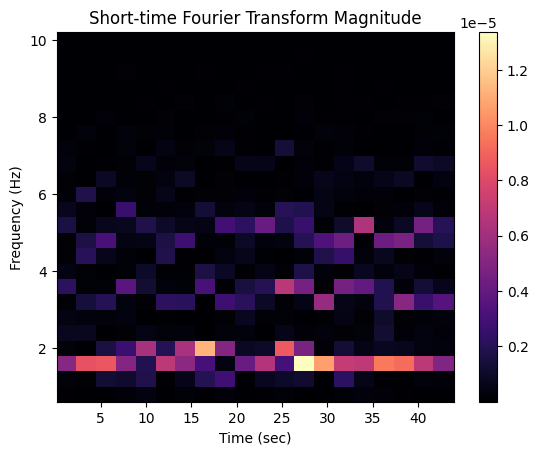

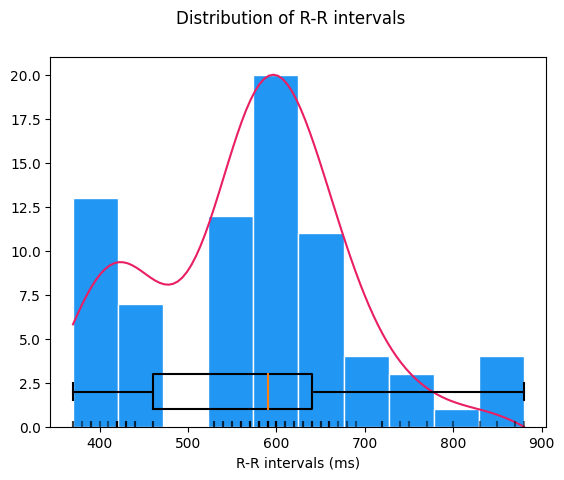

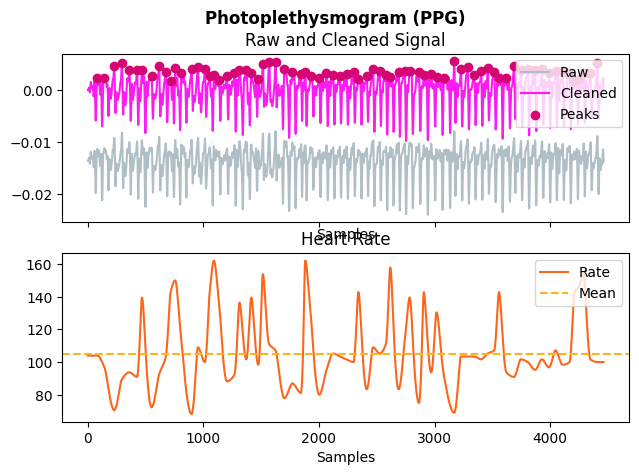

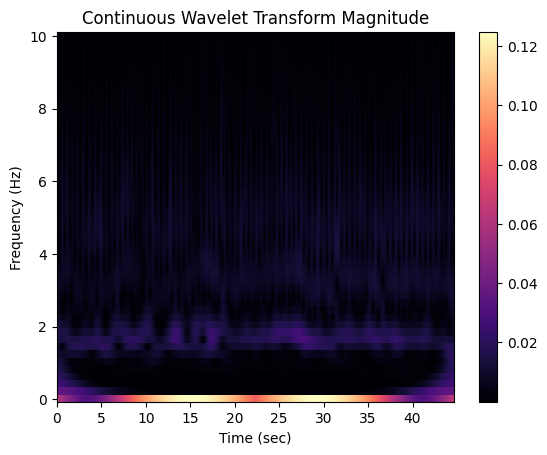

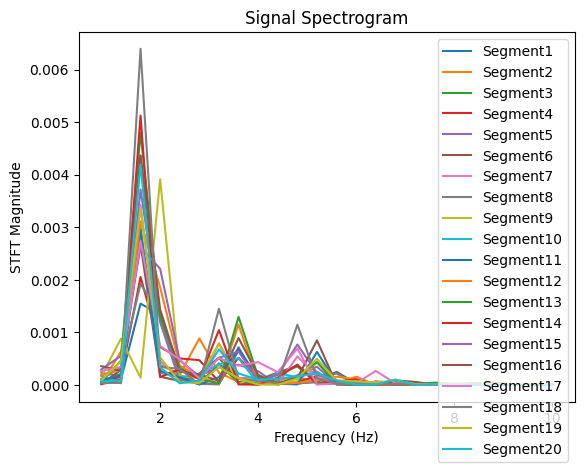

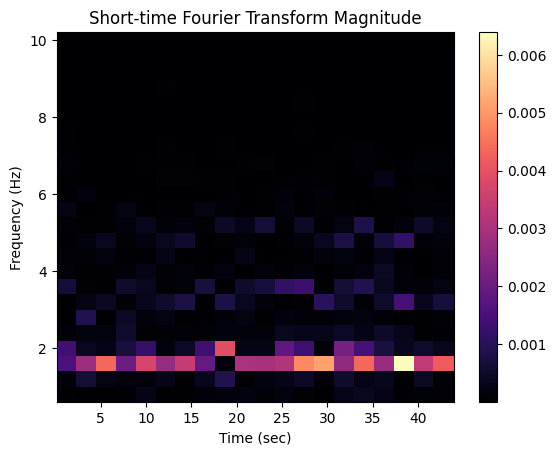

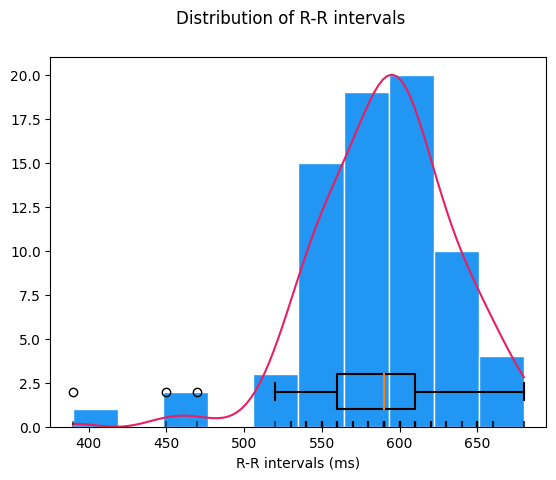

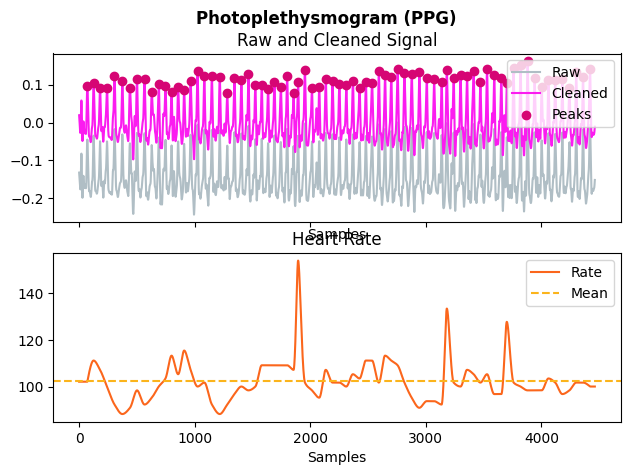

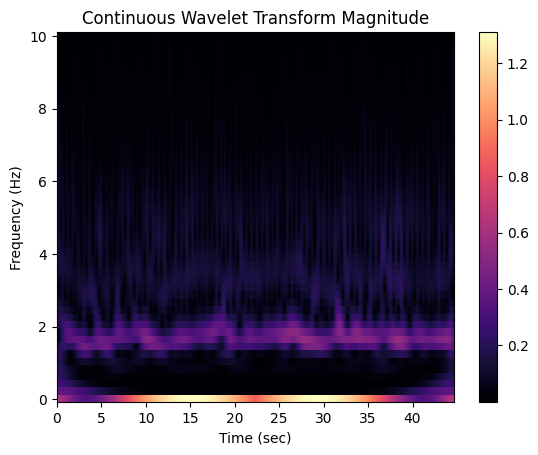

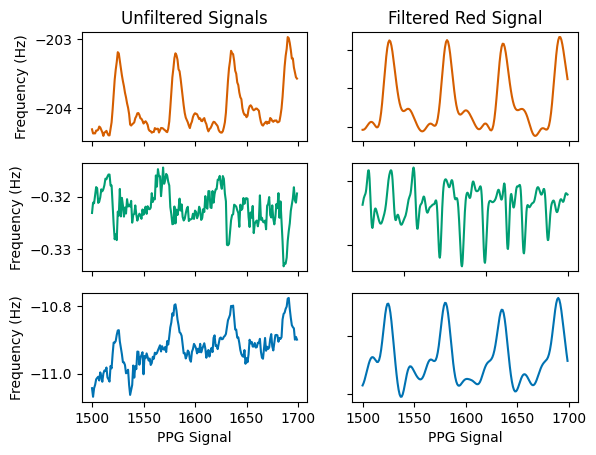

In [3]:
#

import neurokit2 as nk
import pandas as pd
import numpy as np
import heartpy as hp
import pickle
import csv
import sklearn
from scipy.signal import butter, filtfilt, find_peaks , get_window, istft
from librosa.util import fix_length 
import matplotlib.pyplot as plt
import plotly.express as px
import os


def butter_lowpass_filter(data, 
                        sample_rate, 
                        lowcut = 8, 
                        order = 3):
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    #high = highcut / nyq
    b, a = butter(order, [low], btype='low')
    y = filtfilt(b, a, data)
    
    return y

def preprocess(ppg_signal, sampling_rate, channel, folder):
    path = '/home/jazzy/Documents/PPS-Project/Analysis/'
    ppg_clean = nk.ppg_clean(ppg_signal, sampling_rate)
    ppg_resample = nk.signal_resample(ppg_clean, len(ppg_clean), sampling_rate, desired_sampling_rate = 100, method = 'interpolation')
    wd, m = hp.process(ppg_resample, 100)
    rol_mean = wd['rolling_mean']
    #indices = np.asarray([(n, 200+n) for n in range(0, 4400, 200)])
    #indices =  indices + [(4400, 4464)]
    detrend = ppg_resample - rol_mean
    #segmented_ppg = [detrend[v1:v2] for (v1, v2) in indices]
    #for segment in segmented_ppg:
    filtered_signal = butter_lowpass_filter(data = detrend,
                                        sample_rate = 100)

    #filtered_signal = np.concatenate(segmented_ppg)
    amp = 2 * np.sqrt(2)
    len(filtered_signal)
    f, t, Zxx = nk.signal_timefrequency(filtered_signal, 100, min_frequency=0.8, max_frequency=10, method='stft', 
    window_type='boxcar', show = True, analytical_signal = False)
    np.savetxt(f"{path}/{folder}_STFT_{channel}.csv", Zxx, delimiter=",")
    N = N = 10*sampling_rate
    time = np.arange(N) / float(sampling_rate)
    Zxx  = np.where(np.abs(Zxx) >= amp/20, Zxx, 0)
    window = get_window('boxcar', 4486, )
    nperseg = int(2 / 0.8 * 100)
    time, xrec = istft(Zxx, fs = 100, window = 'boxcar')
    #How do I get the values? It graphs but doesn't allow for analyzing?
    stft_peak_index, properties = find_peaks(filtered_signal)
    
    analyze(filtered_signal, stft_peak_index = stft_peak_index, folder = folder, channel = channel)
    return filtered_signal


def analyze(ppg_data, folder,channel, stft_peak_index,
            sampling_rate = 100):
    path = f'/home/jazzy/Documents/PPS-Project/Analysis/{folder}/'
    df, info = nk.ppg_process(ppg_data, sampling_rate)
    hrv_time = nk.hrv_time(df,sampling_rate, show = True)
    hrv_freq = nk.hrv_frequency(df, sampling_rate)
    shannon = nk.entropy_shannon(ppg_data, symbolize=3)
    entropy_svd = nk.entropy_svd(ppg_data)
    entropy_sample = nk.entropy_sample(ppg_data)
    hrv_time = hrv_time.to_dict()
    hrv_freq = hrv_freq.to_dict()
    out = {'shannon':shannon, 'SampEn':entropy_sample, 'Entropy_SVD':entropy_svd}
    hrv_time.update(hrv_freq)
    hrv_time.update(out)
    df.to_csv(f'{path}/Ppg_analysis_{folder}_{channel}.csv')
    
    N = N = 10*sampling_rate
    time = np.arange(N) / float(sampling_rate)
    info['Peaks'] = ppg_data[stft_peak_index]
    signals, info = nk.ppg_process(ppg_data, sampling_rate=100)
    nk.ppg_plot(signals)
    with open(f'HRV_data{channel}.csv', 'w') as f:
        for key in hrv_time.keys():
            f.write("%s,%s\n"%(key,hrv_time[key]))
    gather_cwt_data(ppg_data, 
                        channel = channel, 
                        folder = folder)
    return ppg_data
    


def gather_cwt_data(ppg_data,channel,folder, sampling_rate = 100,):
    f, t, cwtm = nk.signal_timefrequency(ppg_data, int(sampling_rate), method = 'cwt', max_frequency = 10,
    mode='complex', show = True)
    path2 ='/home/jazzy/Documents/PPS-Project/Analysis/CWT_Analysis'
    np.savetxt(f"{path2}/cwt_freq_{folder}_{channel}.csv", f, delimiter=",")
    np.savetxt(f"{path2}/cwt_time._{folder}_{channel}.csv", t, delimiter=",")
    np.savetxt(f"{path2}/cwt_cwtm_{folder}_{channel}.csv", cwtm, delimiter=",")

def analyze_all_channels(file, dataframe, visualise:bool = False):
    filename = file
    folder = filename.strip('.csv')
    print(folder)
    timer = dataframe['time'].values * 1000
    sampling_rate = hp.get_samplerate_mstimer(timer)
    filtered_ppg = pd.DataFrame()
    filtered_ppg['time'] = dataframe['time']
    filtered_ppg['sample_rate'] = 100
    
    for column in dataframe:
        if column == 'time':
            pass
        
        else:
            data = dataframe[column].values
            print(column)
            filtereddata = preprocess(ppg_signal = data, 
                        sampling_rate = sampling_rate, 
                        folder=folder, 
                        channel=column)
            filtered_ppg[column] = filtereddata
        
    
    filtered_ppg.to_csv(f'/home/jazzy/Documents/PPS-Project/Filtered_PPG/filtered_{filename}')

    if visualise == True:

        Red = dataframe['Red']
        Green = dataframe['Green']
        Blue = dataframe['Blue']

        Filtered_Red =  filtered_ppg['Red']
        Filtered_Green = filtered_ppg['Green']
        Filtered_Blue = filtered_ppg['Blue']


        fig,axs = plt.subplots(3,2)
        axs[0, 0].plot(Red[1500:1700], c = '#d55e00', label = 'Red Channel')
        axs[0, 0].set_title('Unfiltered Signals')
        axs[0, 1].plot(Filtered_Red[1500:1700],c ='#d55e00', label = 'Red Channel')
        axs[0, 1].set_title('Filtered Red Signal')
        axs[1, 0].plot(Green[1500:1700], c ='#009e73', label = 'Green Channel')
        axs[1, 1].plot(Filtered_Green[1500:1500+int(5 * 100)],c ='#009e73', label = 'Green Channel')
        axs[2, 0].plot(Blue[1500:1700],c = '#0072b2', label= 'Blue Channel')
        axs[2, 1].plot(Filtered_Blue[1500:1700],c = '#0072b2' , label = 'Blue Channel')
        for ax in axs.flat:
            ax.set(xlabel='PPG Signal', ylabel='Frequency (Hz)')
            ax.label_outer()

        
        plt.savefig(f'/home/jazzy/Documents/PPS-Project/Filtered_PPG/cb_{filename}.png', dpi='figure', format = 'png')
        plt.show()
        

if __name__ == "__main__":
    os.chdir('/home/jazzy/Documents/PPS-Project/Raw_PPG_Files')
    file = '2022-06-07_09-15-58.csv'
    dataframe = pd.read_csv(file, index_col=0)
    analyze_all_channels(file, dataframe, visualise=True)